In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\okarl\Desktop\diploma-thesis\ntbks`


In [2]:
using Plots
using StatsPlots
using JLD
using Statistics
using DataFrames
using ColorSchemes
using LaTeXStrings
using KernelDensity

In [3]:
DATA_PATH = "../results/"

function load_results(path, n_pars; adjusted=false)
    files = readdir(path)

    results = zeros(length(files), n_pars, 5)
    total_sims = 0

    for i in axes(files)[1]
        data = load(path * files[i])
        
        total_sims += sum(data["total_sims"])

        if adjusted
            data = data["adjusted_particles"]
        else
            data = data["particles"]
        end

        # mode
        for j in axes(data)[1]
            kd = kde(data[j, :])
            results[i, j, 1] = kd.x[argmax(kd.density)]
        end
        # median
        results[i, :, 2] = median(data, dims=2)
        # std
        results[i, :, 3] = std(data, dims=2)

        # credible interval/confidence interval
        results[i, :, 4] = hcat([quantile(data[i, :], 0.025) for i in 1:size(data, 1)]) # lower
        results[i, :, 5] = hcat([quantile(data[i, :], 0.975) for i in 1:size(data, 1)]) # upper
    end

    total_sims /= length(files)
    println(total_sims)
    return results
end;


function RMSE(true_params, parameters, stds)
    true_params = reshape(true_params, ((1, size(true_params)[1])))
    return mean(sqrt.(((parameters .- true_params).^2 + stds.^2) ./ abs.(true_params)))
end;

# FW5p

phi = 0.12  
chi = 1.50  
alpha_0 = -0.327  
alpha_n = 1.79  
alpha_p = 18.43  

In [4]:
TRUE_VALUES_5P = [0.12, 1.50, -0.327, 1.79, 18.43];

In [5]:
print("ABC: ")
fw5p_abc = load_results(DATA_PATH * "result_abc/fw5p_abc/", 5, adjusted=false)
print("Bayes: ")
fw5p_bayes = load_results(DATA_PATH * "result_bayes/fw5p_bayes/", 5);

ABC: 360941.38
Bayes: 300000.0


In [6]:
index_level_1 = ["True", "Mode", "Mode", "Median", "Median", "Lower", "Upper", "Lower", "Upper", "Std", "Std"]
index_level_2 = ["True", "ABC", "Bayes", "ABC", "Bayes", "ABC", "ABC", "Bayes", "Bayes", "ABC", "Bayes"]


column_values = zeros(length(index_level_1), 5)
column_values[1, :] = TRUE_VALUES_5P

for (i, data) in enumerate([fw5p_abc, fw5p_bayes])
    temp = round.(mean(data, dims=1)[1, :, :], digits=4)

    index = i + 1
    column_values[index, :] = temp[:, 1] # mode
    column_values[index + 2, :] = temp[:, 2] # median
    column_values[index + 4 + i - 1, :] = temp[:, 4] # lower
    column_values[index + 5 + i - 1, :] = temp[:, 5] # upper
    column_values[index + 8, :] = temp[:, 3] # std   
end

fw5p_df = DataFrame(Index1=index_level_1, Index2=index_level_2, Phi=column_values[:, 1], Chi=column_values[:, 2], Alpha_0=column_values[:, 3], 
                    Alpha_n=column_values[:, 4], Alpha_p=column_values[:, 5]);

In [7]:
rmse_abc_mode = RMSE(TRUE_VALUES_5P, mean(fw5p_abc[:, :, 1], dims=1), std(fw5p_abc[:, :, 1], dims=1))
rmse_bayes_mode = RMSE(TRUE_VALUES_5P, mean(fw5p_bayes[:, :, 1], dims=1), std(fw5p_bayes[:, :, 1], dims=1));

In [8]:
palette = cgrad(:Set1_4, 4, categorical=true).colors

p1_mode = density(fw5p_abc[:, 1, 1], label="ABC", color=palette[3], linewidth=1.5, legendfontsize=12)
density!(p1_mode, fw5p_bayes[:, 1, 1], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p1_mode, [TRUE_VALUES_5P[1]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p1_mode, L"\phi", titlefontsize=24)

p2_mode = density(fw5p_abc[:, 2, 1], label="ABC", color=palette[3], linewidth=1.5, legendfontsize=12)
density!(p2_mode, fw5p_bayes[:, 2, 1], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p2_mode, [TRUE_VALUES_5P[2]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p2_mode, L"\chi", titlefontsize=24)

p3_mode = density(fw5p_abc[:, 3, 1], label="ABC", color=palette[3], linewidth=1.5, legendfontsize=12)
density!(p3_mode, fw5p_bayes[:, 3, 1], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p3_mode, [TRUE_VALUES_5P[3]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p3_mode, L"\alpha_0", titlefontsize=24)

p4_mode = density(fw5p_abc[:, 4, 1], label="ABC", color=palette[3], linewidth=1.5, legendfontsize=12)
density!(p4_mode, fw5p_bayes[:, 4, 1], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p4_mode, [TRUE_VALUES_5P[4]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p4_mode, L"\alpha_n", titlefontsize=24)

p5_mode = density(fw5p_abc[:, 5, 1], label="ABC", color=palette[3], linewidth=1.5, legendfontsize=12)
density!(p5_mode, fw5p_bayes[:, 5, 1], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p5_mode, [TRUE_VALUES_5P[5]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p5_mode, L"\alpha_p", titlefontsize=24)

plot_layout = (3, 2)
plot_5p_mode =plot(p1_mode, p2_mode, p3_mode, p4_mode, p5_mode,
    layout = plot_layout, leftmargin=6Plots.mm,
    legend=true, size=(900,1600)
);

In [9]:
println(fw5p_df)

11×7 DataFrame
 Row │ Index1  Index2  Phi      Chi      Alpha_0  Alpha_n  Alpha_p 
     │ String  String  Float64  Float64  Float64  Float64  Float64 
─────┼─────────────────────────────────────────────────────────────
   1 │ True    True     0.12     1.5     -0.327    1.79    18.43
   2 │ Mode    ABC      0.2758   1.5646  -0.2531   1.9383  26.3883
   3 │ Mode    Bayes    0.1454   1.5542  -0.5185   2.287   32.4774
   4 │ Median  ABC      0.3156   1.5228  -0.2776   1.9184  26.2675
   5 │ Median  Bayes    0.1428   1.5538  -0.5112   2.3032  31.6417
   6 │ Lower   ABC      0.138    0.2534  -0.5331   1.5122  13.712
   7 │ Upper   ABC      0.6992   2.7124  -0.0891   2.2616  38.9413
   8 │ Lower   Bayes    0.0638   0.6277  -0.7426   1.8698  17.9033
   9 │ Upper   Bayes    0.2469   2.4416  -0.2987   2.8041  42.6307
  10 │ Std     ABC      0.1541   0.7096   0.1224   0.2016   6.9925
  11 │ Std     Bayes    0.0544   0.5494   0.1359   0.2686   7.4427


In [10]:
println("Mode parameters RMSE")
println("ABC:     $rmse_abc_mode")
println("Bayes:   $rmse_bayes_mode")

Mode parameters RMSE
ABC:     1.5041346465034322
Bayes:   1.2278969891092864


### Mode parameters

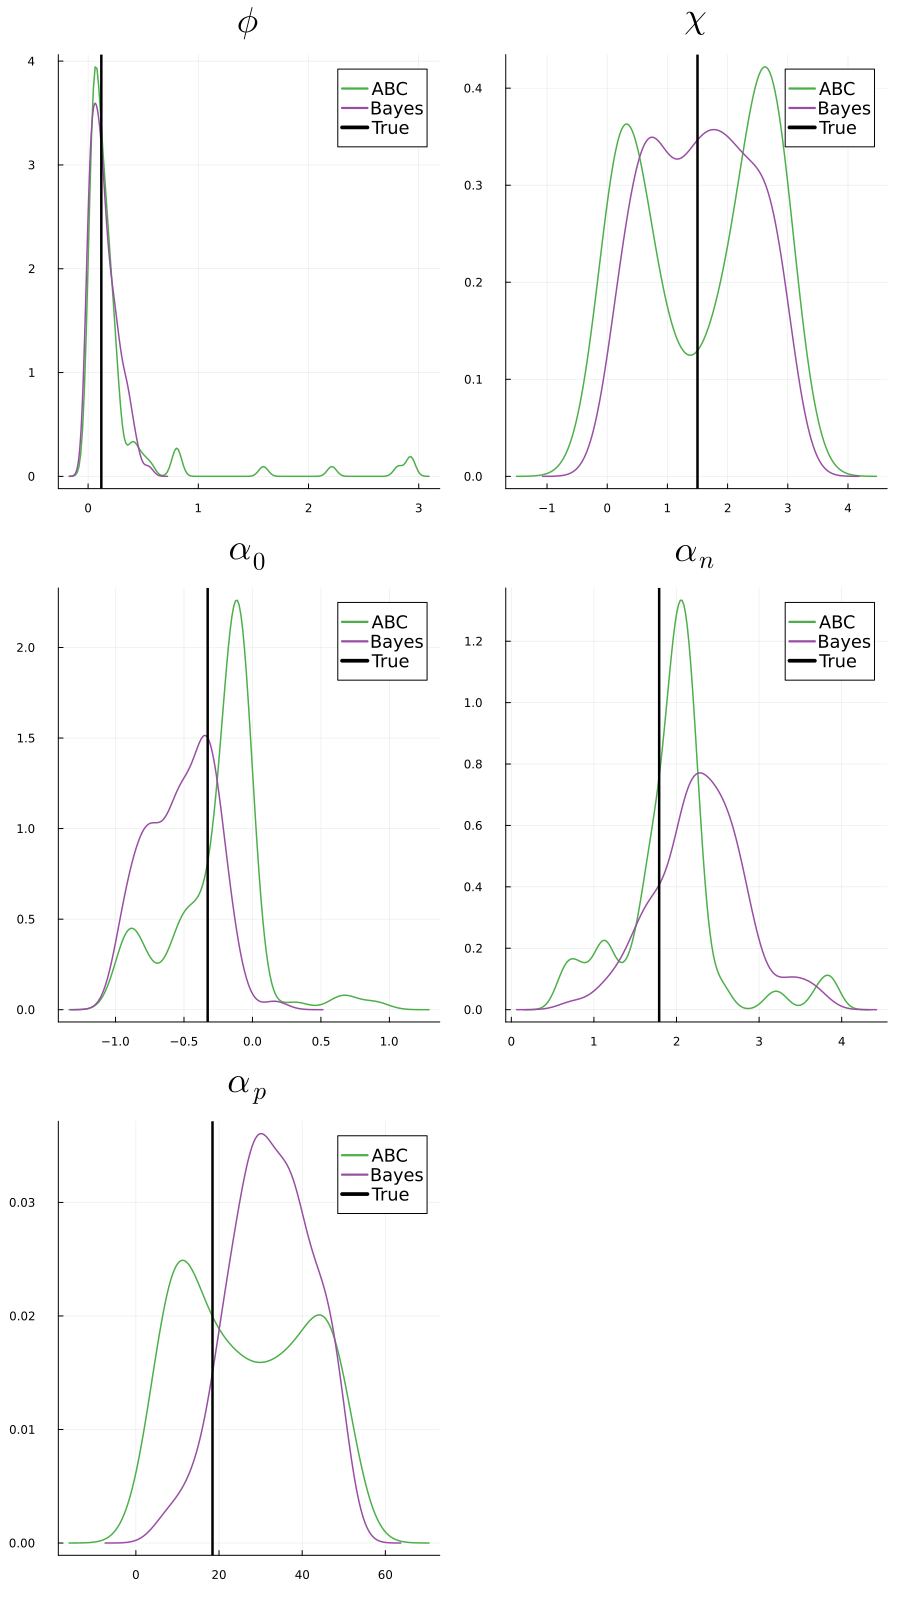

In [11]:
plot_5p_mode